In [32]:
#引入相关包
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


In [33]:
#相关参数
n_epochs = 30   #训练的轮次
batch_size = 64   #batch_size
learning_rate = 0.01   #学习率
momentum = 0.5     #momentum梯度下降时的超参数
log_interval = 10  #画图的记录点

In [34]:
#设置训练集和测试集
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                            transform=torchvision.transforms.ToTensor(),),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                            transform=torchvision.transforms.ToTensor(),),
    batch_size=batch_size, shuffle=True)


In [35]:

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv2d(channels, channels,
        kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels,
        kernel_size=3, padding=1)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x + y)

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv2_drop = nn.Dropout2d()
        self.rblock1 = ResidualBlock(10)
        self.rblock2 = ResidualBlock(20)
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)  

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = self.rblock1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))  
        x = self.rblock2(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x)) 
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1) 

network = Net()

In [37]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.rblock1 = ResidualBlock(10)
        self.rblock2 = ResidualBlock(20)
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)  

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = self.rblock1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  
        x = self.rblock2(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)
        return F.softmax(x, dim=1) 

# network = Net2()

In [38]:
#梯度优化方式采用SGD，带有momentum
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

#用于之后画图时候展示损失函数的下降过程
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

loss_f = nn.CrossEntropyLoss()  #这里我们使用交叉熵损失函数


In [39]:
#训练模型的函数
def train(epoch):
    loop = tqdm(train_loader, leave=True)
    loss_all = 0
    network.train()  #表示进入了测试模式
    for batch_idx, (data, target) in enumerate(loop):
        optimizer.zero_grad()  #旧的梯度清零
        output = network(data)  #正向传播
        loss = loss_f(output, target)  #计算损失
        loss.backward()    #计算梯度
        optimizer.step()   #梯度下降
        loss_all += loss  #计算dataset的总loss
        loop.set_postfix(loss=loss.item())  #画图相关

        #每隔一段时间记录下当前的loss以便画图
        if batch_idx % log_interval == 0:
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))

#测试模型的函数
def test(epoch):
    network.eval()   #表明进入测试模式
    test_loss = 0      #测试的总损失
    correct_all = 0         #测试的总正确数量
    correct = [0] * 10  # 每个数字类别的正确数量
    count = [0] * 10  # 每个数字类别的样本数量
    with torch.no_grad():  #在测试的时候需要取消模型的梯度
        for data, target in test_loader:
            output = network(data)
            test_loss += loss_f(output, target)
            pred = output.data.max(1, keepdim=True)[1].squeeze(1)
            target = target.data.view_as(pred)
            correct_all += pred.eq(target).sum()
            for i in range(len(target)):
                count[target[i]]+=1
                if target[i]==pred[i]:
                    correct[target[i]]+=1

            

    test_loss /= (len(test_loader.dataset)/batch_size) 
    test_losses.append(test_loss.item())
    print('Epoch: {},Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,test_loss, correct_all, len(test_loader.dataset),100. * correct_all / len(test_loader.dataset)))
    for i in range(10):
        accuracy = 100. * correct[i] / count[i]
        print('Digit {}: Accuracy: {}/{} ({:.0f}%)'.format(i, correct[i], count[i], accuracy) ,end=None)
    






In [40]:
test(0)
#开始训练


Epoch: 0,Test set: Avg. loss: 2.3137, Accuracy: 987/10000 (10%)

Digit 0: Accuracy: 0/980 (0%)
Digit 1: Accuracy: 0/1135 (0%)
Digit 2: Accuracy: 0/1032 (0%)
Digit 3: Accuracy: 0/1010 (0%)
Digit 4: Accuracy: 0/982 (0%)
Digit 5: Accuracy: 0/892 (0%)
Digit 6: Accuracy: 16/958 (2%)
Digit 7: Accuracy: 0/1028 (0%)
Digit 8: Accuracy: 971/974 (100%)
Digit 9: Accuracy: 0/1009 (0%)


In [41]:
for epoch in range(1, n_epochs + 1):
    train(epoch) 
    test(epoch)

100%|██████████| 938/938 [00:33<00:00, 28.12it/s, loss=2.3] 


Epoch: 1,Test set: Avg. loss: 2.3126, Accuracy: 1256/10000 (13%)

Digit 0: Accuracy: 0/980 (0%)
Digit 1: Accuracy: 0/1135 (0%)
Digit 2: Accuracy: 0/1032 (0%)
Digit 3: Accuracy: 3/1010 (0%)
Digit 4: Accuracy: 0/982 (0%)
Digit 5: Accuracy: 0/892 (0%)
Digit 6: Accuracy: 312/958 (33%)
Digit 7: Accuracy: 0/1028 (0%)
Digit 8: Accuracy: 941/974 (97%)
Digit 9: Accuracy: 0/1009 (0%)


100%|██████████| 938/938 [00:32<00:00, 28.82it/s, loss=2.3] 


Epoch: 2,Test set: Avg. loss: 2.3096, Accuracy: 2643/10000 (26%)

Digit 0: Accuracy: 0/980 (0%)
Digit 1: Accuracy: 1130/1135 (100%)
Digit 2: Accuracy: 4/1032 (0%)
Digit 3: Accuracy: 750/1010 (74%)
Digit 4: Accuracy: 4/982 (0%)
Digit 5: Accuracy: 0/892 (0%)
Digit 6: Accuracy: 494/958 (52%)
Digit 7: Accuracy: 0/1028 (0%)
Digit 8: Accuracy: 261/974 (27%)
Digit 9: Accuracy: 0/1009 (0%)


100%|██████████| 938/938 [00:31<00:00, 29.76it/s, loss=2.29]


Epoch: 3,Test set: Avg. loss: 2.2319, Accuracy: 3884/10000 (39%)

Digit 0: Accuracy: 907/980 (93%)
Digit 1: Accuracy: 1130/1135 (100%)
Digit 2: Accuracy: 53/1032 (5%)
Digit 3: Accuracy: 717/1010 (71%)
Digit 4: Accuracy: 383/982 (39%)
Digit 5: Accuracy: 0/892 (0%)
Digit 6: Accuracy: 429/958 (45%)
Digit 7: Accuracy: 0/1028 (0%)
Digit 8: Accuracy: 0/974 (0%)
Digit 9: Accuracy: 265/1009 (26%)


100%|██████████| 938/938 [00:30<00:00, 30.64it/s, loss=1.88]


Epoch: 4,Test set: Avg. loss: 1.6778, Accuracy: 7988/10000 (80%)

Digit 0: Accuracy: 919/980 (94%)
Digit 1: Accuracy: 1113/1135 (98%)
Digit 2: Accuracy: 902/1032 (87%)
Digit 3: Accuracy: 827/1010 (82%)
Digit 4: Accuracy: 842/982 (86%)
Digit 5: Accuracy: 0/892 (0%)
Digit 6: Accuracy: 911/958 (95%)
Digit 7: Accuracy: 945/1028 (92%)
Digit 8: Accuracy: 735/974 (75%)
Digit 9: Accuracy: 794/1009 (79%)


100%|██████████| 938/938 [00:30<00:00, 30.89it/s, loss=1.64]


Epoch: 5,Test set: Avg. loss: 1.5720, Accuracy: 8970/10000 (90%)

Digit 0: Accuracy: 960/980 (98%)
Digit 1: Accuracy: 1113/1135 (98%)
Digit 2: Accuracy: 926/1032 (90%)
Digit 3: Accuracy: 891/1010 (88%)
Digit 4: Accuracy: 861/982 (88%)
Digit 5: Accuracy: 696/892 (78%)
Digit 6: Accuracy: 891/958 (93%)
Digit 7: Accuracy: 924/1028 (90%)
Digit 8: Accuracy: 821/974 (84%)
Digit 9: Accuracy: 887/1009 (88%)


100%|██████████| 938/938 [00:30<00:00, 30.59it/s, loss=1.76]


Epoch: 6,Test set: Avg. loss: 1.5591, Accuracy: 9111/10000 (91%)

Digit 0: Accuracy: 961/980 (98%)
Digit 1: Accuracy: 1112/1135 (98%)
Digit 2: Accuracy: 922/1032 (89%)
Digit 3: Accuracy: 889/1010 (88%)
Digit 4: Accuracy: 944/982 (96%)
Digit 5: Accuracy: 804/892 (90%)
Digit 6: Accuracy: 901/958 (94%)
Digit 7: Accuracy: 924/1028 (90%)
Digit 8: Accuracy: 845/974 (87%)
Digit 9: Accuracy: 809/1009 (80%)


100%|██████████| 938/938 [00:30<00:00, 30.68it/s, loss=1.69]


Epoch: 7,Test set: Avg. loss: 1.5426, Accuracy: 9272/10000 (93%)

Digit 0: Accuracy: 956/980 (98%)
Digit 1: Accuracy: 1113/1135 (98%)
Digit 2: Accuracy: 920/1032 (89%)
Digit 3: Accuracy: 912/1010 (90%)
Digit 4: Accuracy: 920/982 (94%)
Digit 5: Accuracy: 819/892 (92%)
Digit 6: Accuracy: 913/958 (95%)
Digit 7: Accuracy: 941/1028 (92%)
Digit 8: Accuracy: 883/974 (91%)
Digit 9: Accuracy: 895/1009 (89%)


100%|██████████| 938/938 [00:30<00:00, 30.66it/s, loss=1.65]


Epoch: 8,Test set: Avg. loss: 1.5385, Accuracy: 9309/10000 (93%)

Digit 0: Accuracy: 964/980 (98%)
Digit 1: Accuracy: 1115/1135 (98%)
Digit 2: Accuracy: 940/1032 (91%)
Digit 3: Accuracy: 917/1010 (91%)
Digit 4: Accuracy: 938/982 (96%)
Digit 5: Accuracy: 798/892 (89%)
Digit 6: Accuracy: 920/958 (96%)
Digit 7: Accuracy: 952/1028 (93%)
Digit 8: Accuracy: 872/974 (90%)
Digit 9: Accuracy: 893/1009 (89%)


100%|██████████| 938/938 [00:31<00:00, 29.99it/s, loss=1.58]


Epoch: 9,Test set: Avg. loss: 1.5265, Accuracy: 9416/10000 (94%)

Digit 0: Accuracy: 965/980 (98%)
Digit 1: Accuracy: 1118/1135 (99%)
Digit 2: Accuracy: 977/1032 (95%)
Digit 3: Accuracy: 930/1010 (92%)
Digit 4: Accuracy: 939/982 (96%)
Digit 5: Accuracy: 832/892 (93%)
Digit 6: Accuracy: 911/958 (95%)
Digit 7: Accuracy: 970/1028 (94%)
Digit 8: Accuracy: 866/974 (89%)
Digit 9: Accuracy: 908/1009 (90%)


100%|██████████| 938/938 [00:31<00:00, 29.99it/s, loss=1.59]


Epoch: 10,Test set: Avg. loss: 1.5261, Accuracy: 9423/10000 (94%)

Digit 0: Accuracy: 967/980 (99%)
Digit 1: Accuracy: 1117/1135 (98%)
Digit 2: Accuracy: 977/1032 (95%)
Digit 3: Accuracy: 923/1010 (91%)
Digit 4: Accuracy: 941/982 (96%)
Digit 5: Accuracy: 843/892 (95%)
Digit 6: Accuracy: 920/958 (96%)
Digit 7: Accuracy: 970/1028 (94%)
Digit 8: Accuracy: 887/974 (91%)
Digit 9: Accuracy: 878/1009 (87%)


100%|██████████| 938/938 [00:30<00:00, 30.45it/s, loss=1.59]


Epoch: 11,Test set: Avg. loss: 1.5238, Accuracy: 9442/10000 (94%)

Digit 0: Accuracy: 966/980 (99%)
Digit 1: Accuracy: 1117/1135 (98%)
Digit 2: Accuracy: 965/1032 (94%)
Digit 3: Accuracy: 943/1010 (93%)
Digit 4: Accuracy: 948/982 (97%)
Digit 5: Accuracy: 825/892 (92%)
Digit 6: Accuracy: 923/958 (96%)
Digit 7: Accuracy: 964/1028 (94%)
Digit 8: Accuracy: 888/974 (91%)
Digit 9: Accuracy: 903/1009 (89%)


100%|██████████| 938/938 [00:30<00:00, 30.49it/s, loss=1.6] 


Epoch: 12,Test set: Avg. loss: 1.5193, Accuracy: 9494/10000 (95%)

Digit 0: Accuracy: 971/980 (99%)
Digit 1: Accuracy: 1114/1135 (98%)
Digit 2: Accuracy: 984/1032 (95%)
Digit 3: Accuracy: 946/1010 (94%)
Digit 4: Accuracy: 955/982 (97%)
Digit 5: Accuracy: 841/892 (94%)
Digit 6: Accuracy: 914/958 (95%)
Digit 7: Accuracy: 978/1028 (95%)
Digit 8: Accuracy: 884/974 (91%)
Digit 9: Accuracy: 907/1009 (90%)


100%|██████████| 938/938 [00:30<00:00, 30.65it/s, loss=1.62]


Epoch: 13,Test set: Avg. loss: 1.5177, Accuracy: 9502/10000 (95%)

Digit 0: Accuracy: 961/980 (98%)
Digit 1: Accuracy: 1115/1135 (98%)
Digit 2: Accuracy: 991/1032 (96%)
Digit 3: Accuracy: 946/1010 (94%)
Digit 4: Accuracy: 948/982 (97%)
Digit 5: Accuracy: 848/892 (95%)
Digit 6: Accuracy: 935/958 (98%)
Digit 7: Accuracy: 956/1028 (93%)
Digit 8: Accuracy: 886/974 (91%)
Digit 9: Accuracy: 916/1009 (91%)


100%|██████████| 938/938 [00:31<00:00, 29.95it/s, loss=1.56]


Epoch: 14,Test set: Avg. loss: 1.5152, Accuracy: 9530/10000 (95%)

Digit 0: Accuracy: 965/980 (98%)
Digit 1: Accuracy: 1118/1135 (99%)
Digit 2: Accuracy: 988/1032 (96%)
Digit 3: Accuracy: 960/1010 (95%)
Digit 4: Accuracy: 948/982 (97%)
Digit 5: Accuracy: 844/892 (95%)
Digit 6: Accuracy: 927/958 (97%)
Digit 7: Accuracy: 949/1028 (92%)
Digit 8: Accuracy: 886/974 (91%)
Digit 9: Accuracy: 945/1009 (94%)


100%|██████████| 938/938 [00:31<00:00, 29.89it/s, loss=1.52]


Epoch: 15,Test set: Avg. loss: 1.5104, Accuracy: 9584/10000 (96%)

Digit 0: Accuracy: 967/980 (99%)
Digit 1: Accuracy: 1119/1135 (99%)
Digit 2: Accuracy: 985/1032 (95%)
Digit 3: Accuracy: 950/1010 (94%)
Digit 4: Accuracy: 945/982 (96%)
Digit 5: Accuracy: 861/892 (97%)
Digit 6: Accuracy: 922/958 (96%)
Digit 7: Accuracy: 983/1028 (96%)
Digit 8: Accuracy: 916/974 (94%)
Digit 9: Accuracy: 936/1009 (93%)


100%|██████████| 938/938 [00:31<00:00, 30.07it/s, loss=1.56]


Epoch: 16,Test set: Avg. loss: 1.5126, Accuracy: 9562/10000 (96%)

Digit 0: Accuracy: 971/980 (99%)
Digit 1: Accuracy: 1107/1135 (98%)
Digit 2: Accuracy: 991/1032 (96%)
Digit 3: Accuracy: 929/1010 (92%)
Digit 4: Accuracy: 940/982 (96%)
Digit 5: Accuracy: 864/892 (97%)
Digit 6: Accuracy: 929/958 (97%)
Digit 7: Accuracy: 966/1028 (94%)
Digit 8: Accuracy: 915/974 (94%)
Digit 9: Accuracy: 950/1009 (94%)


100%|██████████| 938/938 [00:33<00:00, 28.28it/s, loss=1.49]


Epoch: 17,Test set: Avg. loss: 1.5085, Accuracy: 9600/10000 (96%)

Digit 0: Accuracy: 963/980 (98%)
Digit 1: Accuracy: 1113/1135 (98%)
Digit 2: Accuracy: 999/1032 (97%)
Digit 3: Accuracy: 951/1010 (94%)
Digit 4: Accuracy: 948/982 (97%)
Digit 5: Accuracy: 853/892 (96%)
Digit 6: Accuracy: 929/958 (97%)
Digit 7: Accuracy: 964/1028 (94%)
Digit 8: Accuracy: 930/974 (95%)
Digit 9: Accuracy: 950/1009 (94%)


100%|██████████| 938/938 [00:30<00:00, 30.28it/s, loss=1.59]


Epoch: 18,Test set: Avg. loss: 1.5095, Accuracy: 9584/10000 (96%)

Digit 0: Accuracy: 971/980 (99%)
Digit 1: Accuracy: 1113/1135 (98%)
Digit 2: Accuracy: 999/1032 (97%)
Digit 3: Accuracy: 943/1010 (93%)
Digit 4: Accuracy: 945/982 (96%)
Digit 5: Accuracy: 852/892 (96%)
Digit 6: Accuracy: 933/958 (97%)
Digit 7: Accuracy: 978/1028 (95%)
Digit 8: Accuracy: 901/974 (93%)
Digit 9: Accuracy: 949/1009 (94%)


100%|██████████| 938/938 [00:35<00:00, 26.65it/s, loss=1.54]


Epoch: 19,Test set: Avg. loss: 1.5056, Accuracy: 9620/10000 (96%)

Digit 0: Accuracy: 970/980 (99%)
Digit 1: Accuracy: 1112/1135 (98%)
Digit 2: Accuracy: 1003/1032 (97%)
Digit 3: Accuracy: 967/1010 (96%)
Digit 4: Accuracy: 965/982 (98%)
Digit 5: Accuracy: 854/892 (96%)
Digit 6: Accuracy: 920/958 (96%)
Digit 7: Accuracy: 985/1028 (96%)
Digit 8: Accuracy: 910/974 (93%)
Digit 9: Accuracy: 934/1009 (93%)


100%|██████████| 938/938 [00:32<00:00, 28.72it/s, loss=1.57]


Epoch: 20,Test set: Avg. loss: 1.5039, Accuracy: 9644/10000 (96%)

Digit 0: Accuracy: 970/980 (99%)
Digit 1: Accuracy: 1116/1135 (98%)
Digit 2: Accuracy: 1003/1032 (97%)
Digit 3: Accuracy: 962/1010 (95%)
Digit 4: Accuracy: 949/982 (97%)
Digit 5: Accuracy: 855/892 (96%)
Digit 6: Accuracy: 936/958 (98%)
Digit 7: Accuracy: 982/1028 (96%)
Digit 8: Accuracy: 919/974 (94%)
Digit 9: Accuracy: 952/1009 (94%)


100%|██████████| 938/938 [00:30<00:00, 30.86it/s, loss=1.52]


Epoch: 21,Test set: Avg. loss: 1.5044, Accuracy: 9634/10000 (96%)

Digit 0: Accuracy: 971/980 (99%)
Digit 1: Accuracy: 1111/1135 (98%)
Digit 2: Accuracy: 1006/1032 (97%)
Digit 3: Accuracy: 963/1010 (95%)
Digit 4: Accuracy: 946/982 (96%)
Digit 5: Accuracy: 865/892 (97%)
Digit 6: Accuracy: 922/958 (96%)
Digit 7: Accuracy: 978/1028 (95%)
Digit 8: Accuracy: 918/974 (94%)
Digit 9: Accuracy: 954/1009 (95%)


100%|██████████| 938/938 [00:33<00:00, 28.08it/s, loss=1.55]


Epoch: 22,Test set: Avg. loss: 1.5033, Accuracy: 9652/10000 (97%)

Digit 0: Accuracy: 971/980 (99%)
Digit 1: Accuracy: 1114/1135 (98%)
Digit 2: Accuracy: 1011/1032 (98%)
Digit 3: Accuracy: 964/1010 (95%)
Digit 4: Accuracy: 935/982 (95%)
Digit 5: Accuracy: 856/892 (96%)
Digit 6: Accuracy: 926/958 (97%)
Digit 7: Accuracy: 980/1028 (95%)
Digit 8: Accuracy: 933/974 (96%)
Digit 9: Accuracy: 962/1009 (95%)


100%|██████████| 938/938 [00:33<00:00, 27.82it/s, loss=1.49]


Epoch: 23,Test set: Avg. loss: 1.5007, Accuracy: 9669/10000 (97%)

Digit 0: Accuracy: 971/980 (99%)
Digit 1: Accuracy: 1115/1135 (98%)
Digit 2: Accuracy: 1006/1032 (97%)
Digit 3: Accuracy: 972/1010 (96%)
Digit 4: Accuracy: 956/982 (97%)
Digit 5: Accuracy: 865/892 (97%)
Digit 6: Accuracy: 929/958 (97%)
Digit 7: Accuracy: 984/1028 (96%)
Digit 8: Accuracy: 911/974 (94%)
Digit 9: Accuracy: 960/1009 (95%)


100%|██████████| 938/938 [00:31<00:00, 29.72it/s, loss=1.49]


Epoch: 24,Test set: Avg. loss: 1.5016, Accuracy: 9666/10000 (97%)

Digit 0: Accuracy: 969/980 (99%)
Digit 1: Accuracy: 1116/1135 (98%)
Digit 2: Accuracy: 1002/1032 (97%)
Digit 3: Accuracy: 968/1010 (96%)
Digit 4: Accuracy: 950/982 (97%)
Digit 5: Accuracy: 872/892 (98%)
Digit 6: Accuracy: 931/958 (97%)
Digit 7: Accuracy: 977/1028 (95%)
Digit 8: Accuracy: 928/974 (95%)
Digit 9: Accuracy: 953/1009 (94%)


100%|██████████| 938/938 [00:32<00:00, 29.24it/s, loss=1.53]


Epoch: 25,Test set: Avg. loss: 1.4998, Accuracy: 9683/10000 (97%)

Digit 0: Accuracy: 974/980 (99%)
Digit 1: Accuracy: 1118/1135 (99%)
Digit 2: Accuracy: 993/1032 (96%)
Digit 3: Accuracy: 962/1010 (95%)
Digit 4: Accuracy: 955/982 (97%)
Digit 5: Accuracy: 867/892 (97%)
Digit 6: Accuracy: 924/958 (96%)
Digit 7: Accuracy: 986/1028 (96%)
Digit 8: Accuracy: 945/974 (97%)
Digit 9: Accuracy: 959/1009 (95%)


100%|██████████| 938/938 [00:33<00:00, 28.20it/s, loss=1.52]


Epoch: 26,Test set: Avg. loss: 1.5009, Accuracy: 9672/10000 (97%)

Digit 0: Accuracy: 972/980 (99%)
Digit 1: Accuracy: 1117/1135 (98%)
Digit 2: Accuracy: 1006/1032 (97%)
Digit 3: Accuracy: 971/1010 (96%)
Digit 4: Accuracy: 951/982 (97%)
Digit 5: Accuracy: 855/892 (96%)
Digit 6: Accuracy: 936/958 (98%)
Digit 7: Accuracy: 992/1028 (96%)
Digit 8: Accuracy: 919/974 (94%)
Digit 9: Accuracy: 953/1009 (94%)


100%|██████████| 938/938 [00:33<00:00, 27.64it/s, loss=1.57]


Epoch: 27,Test set: Avg. loss: 1.4979, Accuracy: 9700/10000 (97%)

Digit 0: Accuracy: 972/980 (99%)
Digit 1: Accuracy: 1121/1135 (99%)
Digit 2: Accuracy: 1008/1032 (98%)
Digit 3: Accuracy: 974/1010 (96%)
Digit 4: Accuracy: 965/982 (98%)
Digit 5: Accuracy: 872/892 (98%)
Digit 6: Accuracy: 935/958 (98%)
Digit 7: Accuracy: 983/1028 (96%)
Digit 8: Accuracy: 917/974 (94%)
Digit 9: Accuracy: 953/1009 (94%)


100%|██████████| 938/938 [00:33<00:00, 28.28it/s, loss=1.49]


Epoch: 28,Test set: Avg. loss: 1.4972, Accuracy: 9710/10000 (97%)

Digit 0: Accuracy: 970/980 (99%)
Digit 1: Accuracy: 1116/1135 (98%)
Digit 2: Accuracy: 1003/1032 (97%)
Digit 3: Accuracy: 972/1010 (96%)
Digit 4: Accuracy: 957/982 (97%)
Digit 5: Accuracy: 875/892 (98%)
Digit 6: Accuracy: 934/958 (97%)
Digit 7: Accuracy: 995/1028 (97%)
Digit 8: Accuracy: 923/974 (95%)
Digit 9: Accuracy: 965/1009 (96%)


100%|██████████| 938/938 [00:31<00:00, 29.32it/s, loss=1.5] 


Epoch: 29,Test set: Avg. loss: 1.4965, Accuracy: 9718/10000 (97%)

Digit 0: Accuracy: 973/980 (99%)
Digit 1: Accuracy: 1121/1135 (99%)
Digit 2: Accuracy: 1013/1032 (98%)
Digit 3: Accuracy: 981/1010 (97%)
Digit 4: Accuracy: 965/982 (98%)
Digit 5: Accuracy: 865/892 (97%)
Digit 6: Accuracy: 924/958 (96%)
Digit 7: Accuracy: 988/1028 (96%)
Digit 8: Accuracy: 933/974 (96%)
Digit 9: Accuracy: 955/1009 (95%)


100%|██████████| 938/938 [00:31<00:00, 30.11it/s, loss=1.46]


Epoch: 30,Test set: Avg. loss: 1.4961, Accuracy: 9721/10000 (97%)

Digit 0: Accuracy: 970/980 (99%)
Digit 1: Accuracy: 1120/1135 (99%)
Digit 2: Accuracy: 1003/1032 (97%)
Digit 3: Accuracy: 969/1010 (96%)
Digit 4: Accuracy: 966/982 (98%)
Digit 5: Accuracy: 872/892 (98%)
Digit 6: Accuracy: 938/958 (98%)
Digit 7: Accuracy: 987/1028 (96%)
Digit 8: Accuracy: 933/974 (96%)
Digit 9: Accuracy: 963/1009 (95%)


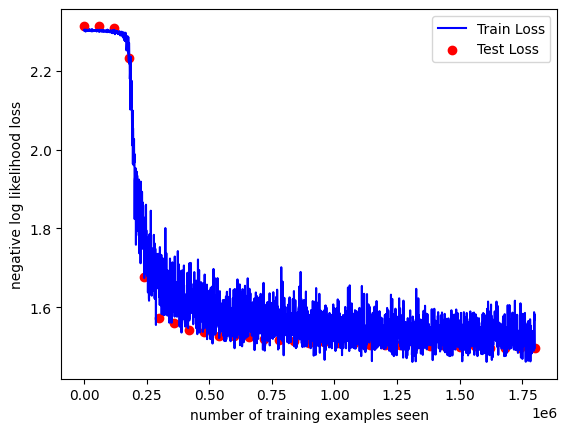

In [42]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

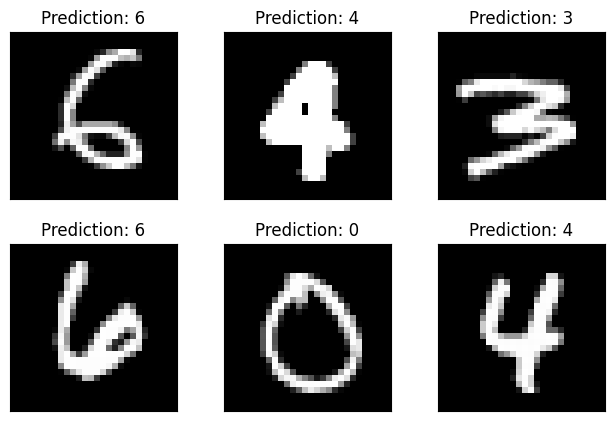

In [43]:
#这里是验证的相关代码  可以直观的展示我们的预测结果  可以看到相关的结果预测的还是非常的准确的
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = network(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()